`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022
 Выпонила: Рудская Ирина
 Вариант №17`

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Лабораторная работа №6: Машины опорных векторов  

В практических примерах ниже показано:   

* как классифицировать данные с помощью модели SVM    
* как использовать конвейеры для подгонки модели и применения её к новым данным

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: SVM 

*Данные*: `default_of_credit_card_clients` 

*Источник*: https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv

# Указания к выполнению


## Загружаем пакеты

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка символьных показателей
from sklearn.preprocessing import LabelEncoder
# для таймера
import time
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency

# загрузка пакетов: модели -------------------------------------------------
# SVM
from sklearn.svm import SVC
# логистическая рагрессия
from sklearn.linear_model import LogisticRegression
# стандартизация
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# конвейеры
from sklearn.pipeline import make_pipeline
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# сводка по точности классификации
from sklearn.metrics import classification_report

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [3]:
# константы
# ядро для генератора случайных чисел
my_seed = 17
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков: 
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [4]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). Задача: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. Источник данных: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. Набор данных был загружен из репозитория UCI (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) 12.10.2021.

* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);
* `SEX` – пол: 1 = мужской, 2 = женский;
* `EDUCATION` – образование: 1 = аспирантура, 2 = университет, 3 = старшая школа, 4 = другое;
* `MARRIAGE` – семейное положение: 1 = женат/замужем, 2 = одинок, 3 = другое;
* `AGE` – возраст, лет;
* `PAY_0`, `PAY_2`, ..., `PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года: -1 = платёж внесён вовремя, 1 = платёж внесён с опозданием на 1 месяц; 2 = с опозданием на 2 месяца, и т.д., 9 = с опозданием на 9 месяцев и более;
* `BILL_AMT1`, ..., `BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;
* `PAY_AMT1`, ..., `PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).

Зависимая переменная: `Y`

Объясняющие переменные все, кроме: 
`Y`,`PAY_4`, `PAY_5`, `PAY_6`, `BILL_AMT4`, `BILL_AMT5`, `BILL_AMT6`, `PAY_AMT1`, ..., `PAY_AMT6`


Загружаем данные во фрейм и выясняем их размерность.  

In [5]:
# загружаем данные
DF_all = pd.read_csv('https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv')

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [6]:
# выбираем нужные значения
DF_raw = DF_all.drop(["PAY_4", "PAY_5", "PAY_6", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                      "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",], axis = 1)

In [7]:
# первые 7 строк столбцов
DF_raw.head(7)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y
0,20000,2,2,1,24,2,2,-1,3913,3102,689,1
1,120000,2,2,2,26,-1,2,0,2682,1725,2682,1
2,90000,2,2,2,34,0,0,0,29239,14027,13559,0
3,50000,2,2,1,37,0,0,0,46990,48233,49291,0
4,50000,1,2,1,57,-1,0,-1,8617,5670,35835,0
5,50000,1,1,2,37,0,0,0,64400,57069,57608,0
6,500000,1,1,2,29,0,0,0,367965,412023,445007,0


In [8]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
Y            int64
dtype: object

Следует обратить внимание на категориальные переменные `SEX`, `EDUCATION`, `MARRIAGE`.

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()` бесполезен для категориальных столбцов, поэтому рассчитаем частоты категорий по каждому столбцу. Для вывода отчёта воспользуемся форматированием на Markdown.   

In [9]:
df_Y_EDUCATION = pd.crosstab(DF_raw['Y'], DF_raw['EDUCATION'])
df_Y_EDUCATION

EDUCATION,0,1,2,3,4,5,6
Y,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [10]:
df_Y_MARRIAGE = pd.crosstab(DF_raw['Y'], DF_raw['MARRIAGE'])
df_Y_MARRIAGE

MARRIAGE,0,1,2,3
Y,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [11]:
df_Y_SEX = pd.crosstab(DF_raw['Y'], DF_raw['SEX'])
df_Y_SEX

SEX,1,2
Y,,
0,9015,14349
1,2873,3763


Перед подсчетом статистик обратим внимание:

* в столбце `EDUCATION` есть значения `0`, `5`, `6`, которые будем считать как пропуски 
* в столбце `MARRIAGE` есть значение `0`, которое тоже будем считать как пропуск  

Поэтому заменим эти значения на пропуски для более удобной обработки результатов.

In [12]:
# для выборки
df_DF_raw = pd.DataFrame(DF_raw)
df_DF_raw['EDUCATION'] = df_DF_raw['EDUCATION'].replace(0, np.nan)
df_DF_raw['EDUCATION'] = df_DF_raw['EDUCATION'].replace(5, np.nan)
df_DF_raw['EDUCATION'] = df_DF_raw['EDUCATION'].replace(6, np.nan)
df_DF_raw['MARRIAGE'] = df_DF_raw['MARRIAGE'].replace(0, np.nan)
DF_raw = df_DF_raw

In [13]:
# считаем частоты по столбцам, учитывая пропуски

for col in DF_raw.columns[DF_raw.columns == 'SEX'] :
    freq_col = DF_raw[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))

for col in DF_raw.columns[DF_raw.columns == 'EDUCATION'] :
    freq_col = DF_raw[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    
for col in DF_raw.columns[DF_raw.columns == 'MARRIAGE'] :
    freq_col = DF_raw[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    
    # для сохранения в pdf
    # print('\n', col, '\n', 
    #       '\n'.join(list(map(concat_func, str_names, str_freqs))))

**SEX**</br>`2`:&ensp;&ensp;&ensp;&ensp;0.604</br>`1`:&ensp;&ensp;&ensp;&ensp;0.396

**EDUCATION**</br>`2.0`:&ensp;&ensp;&ensp;&ensp;0.468</br>`1.0`:&ensp;&ensp;&ensp;&ensp;0.353</br>`3.0`:&ensp;&ensp;&ensp;&ensp;0.164</br>`nan`:&ensp;&ensp;&ensp;&ensp;0.012</br>`4.0`:&ensp;&ensp;&ensp;&ensp;0.004

**MARRIAGE**</br>`2.0`:&ensp;&ensp;&ensp;&ensp;0.532</br>`1.0`:&ensp;&ensp;&ensp;&ensp;0.455</br>`3.0`:&ensp;&ensp;&ensp;&ensp;0.011</br>`nan`:&ensp;&ensp;&ensp;&ensp;0.002

Так как категориальных переменных всего 3, то пропуски легко заметить в этом результате подсчета частот.
Если брать наблюдения `EDUCATION` и `MARRIAGE` отдельно друг от друга, то пропуски в них состовляют, очевидно, не более 2% и 1% соответственно. 

Для проверки выведем их отдельно.

In [14]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF_raw.isna().sum()
nas = np.around(nas / DF_raw.shape[0], 3)
nas[nas > 0]

EDUCATION    0.012
MARRIAGE     0.002
dtype: float64

Подсчитаем, сколько наблюдений мы потеряем, если выбросим все строки хотя бы с одним пропуском.  

In [15]:
na_rows = sum([True for idx, row in DF_raw.iterrows() if any(row.isnull())])
print('Из-за пропусков пропадает ', na_rows, ' строк (',
      np.around(na_rows / DF_raw.shape[0] * 100, 1), '%)', sep='')

Из-за пропусков пропадает 399 строк (1.3%)


Выводы по описательным статистикам: доли классов (`Y`) сопоставимы, наибольшее количество категорий у объясняющей переменной `EDUCATION`. Строки с пропусками составляют не более 2%, поэтому мы уберём их из обучающей выборки.  

In [16]:
# выкидываем пропуски
DF_raw = DF_raw.dropna()
DF_raw.shape

(29601, 12)

## Распределение предикторов внутри классов  по зависимой переменной

Для начала рассмотрим переменные, которые являются категориальными (`EDUCATION`, `MARRIAGE` и `SEX`). Оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [17]:
for col in DF_raw.columns[1:4] :
    con_tab = pd.crosstab(DF_raw[col], DF_raw['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

Результатом проверки стало, что ни одна из категориальных объясняющих переменных не приняла нулевую гипотезу, значит, распределение долей в таблице сопряжённости неслучайно (т.е. два показателя зависимы друг от друга).

Построим корреляционную матрицу для непрерывных переменных. 

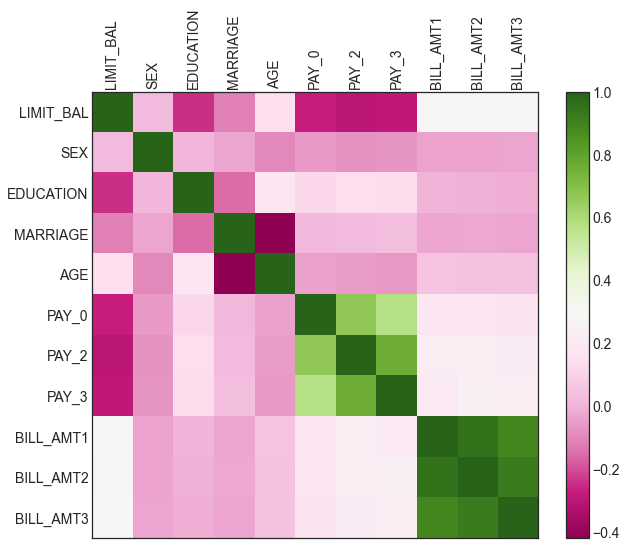

In [18]:
# рассчитываем корреляционную матрицу
corr_mat = DF_raw.drop('Y', axis=1).corr() 
col_names = DF_raw.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими непрерывными переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Напоминание: для переменных `EDUCATION`, `MARRIAGE` и `SEX` она не информативна.

### Создадим фиктивные переменные

In [19]:
# для выборки
DF_copy = DF_raw.copy()
categorical_cols = ['SEX','EDUCATION','MARRIAGE']
DF_copy = pd.get_dummies(DF_copy, columns = categorical_cols)

In [20]:
DF_copy.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y,SEX_1,SEX_2,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
0,20000,24,2,2,-1,3913,3102,689,1,0,1,0,1,0,0,1,0,0
1,120000,26,-1,2,0,2682,1725,2682,1,0,1,0,1,0,0,0,1,0
2,90000,34,0,0,0,29239,14027,13559,0,0,1,0,1,0,0,0,1,0
3,50000,37,0,0,0,46990,48233,49291,0,0,1,0,1,0,0,1,0,0
4,50000,57,-1,0,-1,8617,5670,35835,0,1,0,0,1,0,0,1,0,0


In [21]:
# для проверки
DF_copy.shape

(29601, 18)

In [22]:
# y в начало фрейма для удобства
DF_copy = DF_copy[ ['Y'] + [ col for col in DF_copy.columns if col != 'Y' ] ]
DF_copy.iloc[:, :].head(5)

,Y,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,SEX_1,SEX_2,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
0,1,20000,24,2,2,-1,3913,3102,689,0,1,0,1,0,0,1,0,0
1,1,120000,26,-1,2,0,2682,1725,2682,0,1,0,1,0,0,0,1,0
2,0,90000,34,0,0,0,29239,14027,13559,0,1,0,1,0,0,0,1,0
3,0,50000,37,0,0,0,46990,48233,49291,0,1,0,1,0,0,1,0,0
4,0,50000,57,-1,0,-1,8617,5670,35835,1,0,0,1,0,0,1,0,0


### Отложим 15% наблюдений для прогноза

In [23]:
# наблюдения для моделирования
DF = DF_copy.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_copy.drop(DF.index)

# Преобразование исходных данных и построение моделей  

В качестве альтернативных моделей рассмотрим SVM с различными вариантами ядер и
логистическую регрессию. Причём предварительно преобразуем пространство исходных
показателей с помощью метода главных компонент.



## Стандартизация и переход к главным компонентам 

In [24]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, 2:].values)

# оцениваем объяснённую главными компонентами дисперсию
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
 np.around(frac_var_expl, 3),
 '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))


Доли объяснённой дисперсии по компонентам в PLS:
 [0.208 0.152 0.131 0.126 0.097 0.073 0.063 0.063 0.037 0.027 0.014 0.007
 0.003 0.    0.    0.   ] 
Общая сумма долей: 1.0


Таким образом, первые две главные компоненты объясняют 34.8% разброса 16 объясняющих переменных. 

Теперь объединим функции-преобразователи и оценщики в конвейер с помощью `Pipeline` и оценим точность логистической регрессии с помощью перекрёстной проверки.

## Модель логистической регрессии с перекрёстной проверкой


In [25]:
# данные для обучения моделей
X_train = DF.iloc[:, 1:] 
y_train = DF.iloc[:, 0]

# объединяем в конвейер шкалирование, ГК с 2 компонентами и логит
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(random_state = my_seed, solver = 'lbfgs'))

# будем сохранять точность моделей в один массив
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, 
                     cv = 5, scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3)) 
score_models.append('sc_pca_logit')
print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели sc_pca_logit : 0.785


Для проверки выведем `X_train` и `y_train` (так как они могут быть определены ошибочно).

In [26]:
y_train

28563    0
26595    0
15017    0
3553     0
9040     1
        ..
14779    1
2726     0
17178    0
24996    1
10379    0
Name: Y, Length: 25161, dtype: int64

In [27]:
X_train

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,SEX_1,SEX_2,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
28563,30000,35,0,0,0,27873,27326,27648,0,1,0,0,1,0,0,1,0
26595,120000,30,-2,-2,-2,0,0,0,1,0,1,0,0,0,0,1,0
15017,20000,44,0,0,2,16401,9620,9264,1,0,0,1,0,0,1,0,0
3553,40000,27,0,0,-1,32228,38904,4235,0,1,1,0,0,0,0,1,0
9040,20000,52,1,2,0,20838,20212,20148,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14779,30000,25,0,0,0,25115,26287,26602,0,1,1,0,0,0,0,1,0
2726,200000,39,0,0,0,178665,133266,95836,0,1,0,1,0,0,1,0,0
17178,140000,29,0,0,0,100064,95224,104440,0,1,0,1,0,0,1,0,0
24996,80000,47,2,2,2,68250,73424,71691,1,0,0,1,0,0,1,0,0


Значения опеределны верно.

## SVM с перекрёстной проверкой 

Построим несколько вариантов модели SVM с различными ядерными функциями.

In [28]:
pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state = my_seed))

# настроим параметры SVM с помощью сеточного поиска
param_range = [0.0001, 0.001] #[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__degree' : [2, 3],
               'svc__kernel': ['poly']}]

# разбиения для перекрёстной проверки
kfold = KFold(n_splits = 5, random_state = my_seed, shuffle = True)

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, 
                  scoring = 'accuracy', refit = True, cv = kfold, 
                  n_jobs = -1)

# таймер
tic = time.perf_counter()
# запускаем сеточный поиск
gs = gs.fit(X_train, y_train)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 459.25 секунд


In [29]:
# точность лучшей модели
np.around(gs.best_score_, 3)

0.783

In [30]:
# параметры лучшей модели
# * ядерная функция
gs.best_estimator_.get_params()['svc__kernel']

'linear'

In [31]:
# * параметр регуляризации
gs.best_estimator_.get_params()['svc__C']

0.001

In [32]:
# * коэффициент ядерной функции (для ядер 'rbf', 'poly' и 'sigmoid')
gs.best_estimator_.get_params()['svc__gamma']

'scale'

In [33]:
# * степень полинома (для ядра 'poly')
gs.best_estimator_.get_params()['svc__degree']

3


📚 **Пример визуализации небольшого дерева**

Посмотреть результаты сеточного поиска можно в объектах:

* `gs.cv_results_['params']` – список сочетаний параметров;
* `gs.cv_results_['mean_test_score']` – значения для сочетаний параметров (средние по блокам перекрёстной проверки).


In [34]:
# записываем точность
score.append(np.around(gs.best_score_, 3))
score_models.append('sc_pca_svc')
print('Acc с перекрёстной проверкой',
 '\nдля модели', score_models[1], ':', score[1])

Acc с перекрёстной проверкой 
для модели sc_pca_svc : 0.783


# Метод kNN

In [35]:
k_range = list(range(1,64))
weight_options = ["uniform", "distance"]

pipe_knn = Pipeline(steps=[('standard', StandardScaler()), 
                           ('PCA', PCA(n_components = 5)), 
                           ('knn', KNeighborsClassifier())
                          ])
param_grid = {'knn__n_neighbors': list(range(1,64))}

knn = KNeighborsClassifier()
kfold = KFold(n_splits = 5, random_state = my_seed, shuffle = True)
grid = GridSearchCV(pipe_knn, param_grid, cv = kfold, scoring = 'accuracy')

tic = time.perf_counter()
grid.fit(X_train, y_train)
toc = time.perf_counter()

print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 139.97 секунд


In [36]:
# записываем точность
score.append(np.around(grid.best_score_,3))
score_models.append('sc_pca_knn')

print('Acc с перекрёстной проверкой',
    '\nдля модели',score_models[2],':',score[2])

Acc с перекрёстной проверкой 
для модели sc_pca_knn : 0.803



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [37]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,sc_pca_logit,0.785
1,sc_pca_svc,0.783
2,sc_pca_knn,0.803


#### Вывод

Все модели показывают среднюю точность по показателю $Acc$, однако самой точной оказывается модель, построенная методом `kNN`.

Сделаем прогноз на отложенные наблюдения.   

In [40]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = grid.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      3419
           1       0.61      0.26      0.36      1021

    accuracy                           0.79      4440
   macro avg       0.71      0.60      0.62      4440
weighted avg       0.76      0.79      0.76      4440



#### Вывод

Для выбранной модели:

* Специфичность - `0.95`
* Чувствительность - `0.26`
* Совокупная точность - `0.79`

В целом это говорит о хорошем качестве модели, хотя чувствительность показывает не самый лучший результат. 

Cледует отметить, что в данных бОльшая часть переменных - это категориальные переменные, что ухудшает работу по созданию наиболее точной модели и не позволяет достигнуть точности в 96%.

# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с
примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.
2. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей
предсказательной аналитике, обязательное для более глубокого понимания методологии
машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.